In [21]:
import json
import numpy as np
import torch
import torch.nn.functional as F

from tqdm import tqdm
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from transformer.tokenization import BertTokenizer
from transformer.modeling import TinyBertForSequenceClassification

In [2]:
from task_distill import (
    ColaProcessor,
    MnliProcessor,
    MnliMismatchedProcessor,
    MrpcProcessor,
    Sst2Processor,
    StsbProcessor,
    QqpProcessor,
    QnliProcessor,
    RteProcessor,
    WnliProcessor,
)
from task_distill import convert_examples_to_features, get_tensor_data

In [3]:
processors = {
    "cola": ColaProcessor,
    "mnli": MnliProcessor,
    "mnli-mm": MnliMismatchedProcessor,
    "mrpc": MrpcProcessor,
    "sst-2": Sst2Processor,
    "sts-b": StsbProcessor,
    "qqp": QqpProcessor,
    "qnli": QnliProcessor,
    "rte": RteProcessor,
    "wnli": WnliProcessor
}

In [4]:
output_modes = {
    "cola": "classification",
    "mnli": "classification",
    "mnli-mm": "classification",
    "mrpc": "classification",
    "sst-2": "classification",
    "sts-b": "regression",
    "qqp": "classification",
    "qnli": "classification",
    "rte": "classification",
    "wnli": "classification"
}

#### Load Dataset

In [5]:
task_name = 'mnli'
processor = processors[task_name]()
output_mode = output_modes[task_name]
label_list = processor.get_labels()
num_labels = len(label_list)
teacher_model_path = '/home/mcao610/scratch/huggingface/bert-base-uncased'

In [6]:
data_dir = '/home/mcao610/scratch/glue_data/MNLI'

In [7]:
examples = []
train_examples = processor.get_train_examples(data_dir)
dev_examples = processor.get_dev_examples(data_dir)
print('- train examples: {}'.format(len(train_examples)))
print('- dev examples: {}'.format(len(dev_examples)))
examples.extend(train_examples)
examples.extend(dev_examples)

if task_name == 'mnli':
    processor = processors['mnli-mm']()
    dev_mismatched_examples = processor.get_dev_examples(data_dir)
    print('- dev mismatched examples: {}'.format(len(dev_mismatched_examples)))
    examples.extend(dev_mismatched_examples)

- train examples: 392702
- dev examples: 9815
- dev mismatched examples: 9832


In [8]:
len(examples)

412349

#### Convert Examples to Features

In [13]:
train_guids = []

for e in examples:
    train_guids.append(e.guid)

In [14]:
tokenizer = BertTokenizer.from_pretrained(teacher_model_path, do_lower_case=True)

In [15]:
max_seq_length = 128
train_features = convert_examples_to_features(examples, label_list, max_seq_length, tokenizer, output_mode)

10/04 08:53:32 PM Writing example 0 of 412349
10/04 08:53:32 PM *** Example ***
10/04 08:53:32 PM guid: train-0
10/04 08:53:32 PM tokens: [CLS] conceptual ##ly cream ski ##mming has two basic dimensions - product and geography . [SEP] product and geography are what make cream ski ##mming work . [SEP]
10/04 08:53:32 PM input_ids: 101 17158 2135 6949 8301 25057 2038 2048 3937 9646 1011 4031 1998 10505 1012 102 4031 1998 10505 2024 2054 2191 6949 8301 25057 2147 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04 08:53:32 PM input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
10/04 08:53:32 PM segment_ids: 0 0 0 0 0 

In [16]:
print(len(train_features))
print(train_features[0])

412349


In [17]:
train_data, all_label_ids = get_tensor_data(output_mode, train_features)

In [18]:
type(train_data)

torch.utils.data.dataset.TensorDataset

In [19]:
train_data.tensors[0].shape

torch.Size([412349, 128])

In [20]:
print(all_label_ids.shape)
print(all_label_ids[:10])

torch.Size([412349])
tensor([1, 0, 0, 0, 1, 0, 1, 0, 2, 2])


In [18]:
train_dataloader = DataLoader(train_data, sampler=SequentialSampler(train_data), batch_size=32)

#### Load Teacher Model

In [19]:
teacher_model = TinyBertForSequenceClassification.from_pretrained(teacher_model_path, num_labels=num_labels)
teacher_model.to('cuda')

09/23 04:57:13 PM Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "pre_trained": "",
  "training": "",
  "transformers_version": "4.6.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

09/23 04:57:16 PM Loading model /home/mcao610/scratch/huggingface/bert-base-uncased/pytorch_model.bin
09/23 04:57:19 PM loading model...
09/23 04:57:19 PM done!
09/23 04:57:19 PM Weights of TinyBertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias', 'fit_dense.weight', 'fit_dense.bias']
09/23 04:57:19 PM

TinyBertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [20]:
cls_features = []
example_ids = []

for batch_ in tqdm(train_dataloader, desc="Evaluating"):
    batch_ = tuple(t.to('cuda') for t in batch_)
    with torch.no_grad():
        input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch_
        logits, atts, reps, pooled = teacher_model(input_ids, segment_ids, input_mask)
        
        cls_features.append(pooled)
        example_ids.append(input_ids)

Evaluating: 100%|██████████| 12886/12886 [16:31<00:00, 13.00it/s]


In [21]:
len(cls_features)

12886

In [22]:
cls_features[0].shape

torch.Size([32, 768])

In [23]:
cls_feature_vectors = torch.cat(cls_features, dim=0)

In [24]:
cls_feature_vectors.shape

torch.Size([412349, 768])

#### K-means

In [25]:
%matplotlib inline

In [26]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [27]:
cls_feature_numpy = cls_feature_vectors.cpu().numpy()

In [28]:
all_label_ids = all_label_ids.cpu().numpy()

In [29]:
CLUSTER_NUMBER = 256
kmeans = KMeans(n_clusters=CLUSTER_NUMBER, random_state=0).fit(cls_feature_numpy)

In [30]:
cluster_centers = kmeans.cluster_centers_

In [31]:
cluster_labels = kmeans.labels_

In [32]:
print(cluster_centers.shape)
print(cluster_labels.shape)

(256, 768)
(412349,)


In [33]:
cluster_labels[:10]

array([252, 215,  12, 141, 245,  70,  51, 115, 127, 178], dtype=int32)

#### Save Clustering IDs

In [34]:
assert len(train_guids) == cluster_labels.shape[0]

In [35]:
cluster_map = {}

for guid, l in zip(train_guids, cluster_labels):
    cluster_map[guid] = int(l)

In [36]:
import json

with open('clusters/cluster_mnli_k{}.json'.format(CLUSTER_NUMBER), 'w') as fp:
    json.dump(cluster_map, fp)

#### Visualization

In [37]:
import random

from sklearn.decomposition import PCA

In [38]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [39]:
vis_data = cls_feature_numpy[:10000, :]
vis_labels = cluster_labels[:10000]

In [40]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(vis_data)

In [41]:
pca_results.shape

(10000, 2)

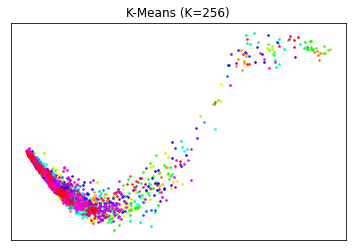

In [42]:
plt.figure(1)

cmap = get_cmap(CLUSTER_NUMBER)

for k in range(CLUSTER_NUMBER):
    cluster_data = vis_labels == k
    plt.scatter(pca_results[cluster_data, 0], pca_results[cluster_data, 1],
                color=cmap(k), marker='.', s=10)

# plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', s=50)
plt.title("K-Means (K={})".format(CLUSTER_NUMBER))
plt.xticks([])
plt.yticks([])
plt.savefig('kmeans.png')
plt.show()

In [43]:
vis_labels = all_label_ids[:10000]

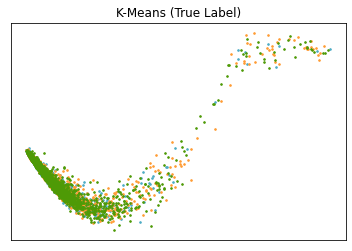

In [44]:
plt.figure(1)

cmap = ['#4EACC5', '#FF9C34', '#4E9A06']

for k in range(3):
    cluster_data = vis_labels == k
    plt.scatter(pca_results[cluster_data, 0], pca_results[cluster_data, 1],
                color=cmap[k], marker='.', s=10)

# plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='black', s=50)
plt.title("K-Means (True Label)")
plt.xticks([])
plt.yticks([])
plt.savefig('ture_label.png')
plt.show()

In [45]:
# merge json
# train_json = json.load(open('clusters/cluster_mnli_k3_train.json'))
# dev_m_json = json.load(open('clusters/cluster_mnli_k3_dev_matched.json'))
# dev_mm_json = json.load(open('clusters/cluster_mnli_k3_dev_mismatched.json'))

# print(len(train_json))
# print(len(dev_m_json))
# print(len(dev_mm_json))

In [46]:
# with open('clusters/cluster_mnli_k{}.json'.format(CLUSTER_NUMBER), 'w') as fp:
#     json.dump({**train_json, **dev_m_json, **dev_mm_json}, fp)